# **TCC PUC MINAS**
### A opini√£o p√∫blica sobre a RFB - An√°lise de sentimentos de tweets
##### Grasiela Peccini

## Importa√ß√£o dos pacotes necess√°rios

In [2]:
import tweepy
import time
import pandas as pd
import csv
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk import word_tokenize
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
%matplotlib inline
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Coleta de dados
Os datasets coletados via API do Twitter foram obtidos com varia√ß√µes do c√≥digo que segue. No exemplo, est√° a coleta dos textos relativos aos identificadores do dataset TASH.

In [ ]:
#dados necess√°rios para a conex√£o √† API do Twitter. Os valores XXX devem ser substitu√≠dos pelas credenciais do usu√°rio
consumer_key = 'XXX'
consumer_secret = 'XXX'
token_key = 'XXX'
token_secret = 'XXX'

def download_tweets(id_file):
    #arquivo para grava√ß√£o dos dados extra√≠dos
    tash_path='D:/Pos_PUC/TCC/Datasets/tash_texto_completo.csv'
    #arquivo para registrar tweets com erro de download
    tash_error_path='D:/Pos_PUC/TCC/Datasets/tash_error_completo.csv'
    #abertura dos arquivos para grava√ß√£o, com codifica√ß√£o UTF-8
    tash_file=open(tash_path,"w", encoding='utf8')
    tash_error=open(tash_error_path,"w", encoding='utf8')
    #para cada id do arquivo, extrai o tweet, trata e grava no arquivo
    with open(id_file) as infile:
        for tweet_id in infile:
            tweet_id = tweet_id.strip()

            try:

                tweet = api.get_status(tweet_id, tweet_mode="extended", start_time="2006-03-21T00:00:00Z")
                texto=tweet.full_text.replace("\"","")
                texto=texto.replace(";","")
                print(tweet.full_text)
                tash_file.write(str(tweet.id)+";\""+texto+"\"\n")
                
            except tweepy.error.TweepError:
                print("tweet com id: ", tweet_id, "n√£o est√° dispon√≠vel")
                tash_error.write(str(tweet.id)+"\n")

            time.sleep(1)
    tash_file.close
    tash_error.close


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(token_key, token_secret)
api = tweepy.API(auth)

download_tweets("D:/Pos_PUC/TCC/Datasets/tash-pt-master/id_file.txt")

## Split da base toRFB em treinamento e teste
Foram separados 5% da base para treinamento. Esses tweets foram manualmente classificados. Registros que possuiam apenas links, emoticons ou refer√™ncias a usu√°rios foram descartados.

In [ ]:
#carrega arquivo de tweets para a RFB
tw_rfb = pd.read_csv('D:/Pos_PUC/TCC/Datasets/toRFB_extract.csv', delimiter=";", encoding='utf-8')
tw_rfb.columns=['id', 'text', 'author_id', 'created_at']
index = tw_rfb[tw_rfb['author_id'] == 18718638].index #remove tweets da RFB
tw_rfb.drop(index, inplace=True)

#divide o conjunto em 5% e 95%
to_rfb_rotular=tw_rfb.sample(frac=0.05, random_state=0)
to_rfb_testar=tw_rfb.drop(to_rfb_rotular.index)
to_rfb_rotular.to_csv("D:/Pos_PUC/TCC/Datasets/Treinamento/toRFB_treino.csv")
to_rfb_testar.to_csv("D:/Pos_PUC/TCC/Datasets/Teste/toRFB_teste.csv")

## Merge da base de treinamento
Processo realizado na ferramenta de escrit√≥rio Calc (LibreOffice). Produzido o arquivo toRFB_e_Mg.csv.

# Carga da base de treinamento

In [178]:
#carrega o dataset de treinamento para o dataframe df_treinamento
df_treinamento = pd.read_csv('D:/Pos_PUC/TCC/Datasets/Datasets_Final/toRFB_e_Mg.csv', encoding='utf-8')
#df_treinamento = pd.read_csv('D:/Pos_PUC/TCC/Datasets/Datasets_Final/Tweets_Mg.csv', encoding='utf-8')
df_treinamento.columns=['text', 'sentiment']

In [65]:
#exibe amostra alet√≥ria de 10 registros da base de treinamento
with pd.option_context('display.max_colwidth', -1):     
  display(df_treinamento[['text', 'sentiment']].sample(n=10, random_state=4))

text  \
5933  Contra febre amarela, vacina√ß√£o √© oferecida 'casa a casa' em Varginha https://t.co/8foULUoRSM https://t.co/OrndOrKwp5                          
7575  Suspeito de tr√°fico de drogas √© detido com mais de R$ 22 mil em Juiz de Fora #G1 https://t.co/J4sKWkRr3n                                       
5303  Escola do Legislativo √© tema de mestrado na Universidade de Portugal https://t.co/owaT3FHztK #SuldeMinas https://t.co/kTaVxgT9Zs               
7434  @PMMG190 - PM prende dupla por tr√°fico de drogas https://t.co/iOt2Dy9SBc                                                                       
7055  Pol√≠cia Civil apresenta dupla presa por tr√°fico de drogas em Patroc√≠nio https://t.co/ACoS7iSTH4 https://t.co/6TGcDP8BKZ                        
5187  RT   Minist√©rio da Sa√∫de liberou R$ 543,5 milh√µes ao estado de Minas Gerais.\nHospitais em Uberaba e Uberl√¢ndia est√£o entre os beneficiados.   
724   Crise? Q crise?! // Mesmo em calamidade financeira, governo de MG compra mais dois helic√≥pteros @UOL  https://t.co/c8K1KqJOjD                  
6290  Grupo √© detido ap√≥s roubo e carreta recuperada em MG https://t.co/Q9vWjPEU2a #SomosTodosDilma #Raynniere #BuyRaynniereOnItunes                 
4022  RT @radioitatiaia: Mesmo em 'calamidade financeira', governo de Minas compra mais dois helic√≥pteros: https://t.co/9PMQRR5fn8 https://t.co/9‚Ä¶   
7872  Dois homens s√£o presos por tr√°fico de drogas em Japonvar, Norte de MG https://t.co/t7RDt62z58 https://t.co/4BaG2DEiE0                          

      sentiment  
5933  1          
7575  1          
5303  1          
7434  1          
7055  1          
5187  1          
724  -1          
6290  1          
4022 -1          
7872  1

## Nuvem de palavras da base de treinamento (sem tratamento)

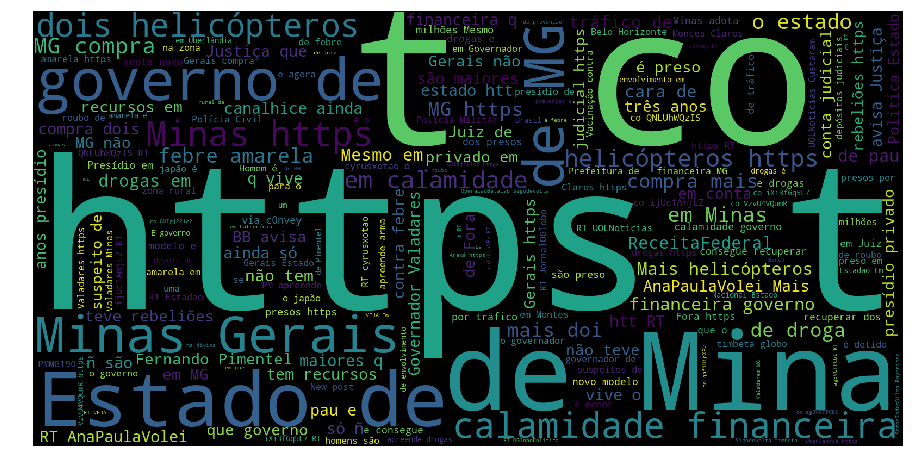

In [6]:
#especifica os par√¢metros, gera a nuvem e exibe a imagem
def nuvem(string):
    wordcloud = WordCloud(background_color='black', width=1600, height=800).generate(string)
    fig, ax = plt.subplots(figsize=(16,8))            
    ax.imshow(wordcloud, interpolation='bilinear')       
    ax.set_axis_off()
    plt.imshow(wordcloud)
    plt.show()

#junta todo o conte√∫do do dataframe em uma √∫nica string
all_content=' '.join(df_treinamento['text'])
nuvem(all_content)

## Defini√ß√£o das fun√ß√µes de tratamento de string

In [179]:
#substitui termos
def replace(string):
    string= re.sub('hahaha{1,}?', 'kkk', string, flags=re.IGNORECASE)
    string= re.sub('hehehe{1,}?', 'kkk', string, flags=re.IGNORECASE)
    string= re.sub('ahah{1,}?', 'kkk', string, flags=re.IGNORECASE)
    string= re.sub('kkkah{1,}?', 'kkk', string, flags=re.IGNORECASE)
    string= re.sub('kkkh{1,}?', 'kkk', string, flags=re.IGNORECASE)
    string= re.sub('k{2,}', 'kkk', string, flags=re.IGNORECASE)
    string= re.sub('√± ', 'n√£o ', string, flags=re.IGNORECASE)
    string= re.sub('nao ', 'n√£o ', string, flags=re.IGNORECASE)
    string= re.sub('vc ', 'voc√™ ', string, flags=re.IGNORECASE)
    string= re.sub('q ', 'que ', string, flags=re.IGNORECASE)
    string= re.sub('vcs ', 'voc√™s ', string, flags=re.IGNORECASE)
    return string

#remove stopwords
def limpa_stop(frase):
    stopwords = ['de','da','um', 'aos','n√©','das', 'e', 'a', 'o', 'no', 'nos','nas', 'do','dos',\
                 'na', 'os', 'as', 'que', 'uma', 'p', 'para', 'pra', 'eu', 'em', 'como', '√©', 'por', 'ao',\
                 'ma', 'esse', 'essa', 'isso','ou','me', 'se','com','rfb','receita','voc√™','voc√™s', 'meu','minha',\
                 'estou','est√°','mg','minas', 'gerais','valadares','dois','mais','htt', 'federal']
    
    frase=frase.split()
    frase=[p for p in frase if p not in stopwords]
    frase=(" ".join(frase))
    return frase

#define e aplica stemmer
def aplica_stemmer(frase):
    stemmer=nltk.stem.RSLPStemmer()
    frase=frase.split()
    frase_nova=[]
    for palavra in frase:
        frase_nova.append(stemmer.stem(palavra))
    frase_nova=(" ".join(frase_nova))
    return frase_nova

#aplica as fun√ß√µes de limpeza e faz mais algumas substitui√ß√µes
def limpaTexto(df, campo):
    
    df[campo] = df[campo].str.lower() 
    df[campo] = df[campo].str.replace(r"http\S+", "").str.replace(r"http", "").str.replace(r"@\S+", "").str.replace("rt ", "")\
    .str.replace(r'[^\w\.\!\?]', " ").str.replace('[!?.\"]', " ").str.replace('@[\w_-]+ ', " ").str.replace(r'[0-9]', "")
    df[campo] = df[campo].apply(replace)
    df[campo] = df[campo].apply(limpa_stop)
    #df[campo]=df[campo].apply(aplica_stemmer)  
    df[campo] = df[campo].str.strip()
    
    return df

## Tratamento da base de treinamento

In [180]:
#limpa a base de treinamento
df_treinamento=limpaTexto(df_treinamento, "text")

In [121]:
#exibe amostra aleat√≥ria da base ap√≥s limpeza 
with pd.option_context('display.max_colwidth', -1):     
  display(df_treinamento[["text", 'sentiment']].sample(n=5, random_state=4))

text  \
1384  pelo entendi coment√°rio infeliz sujeito ser estuprada at√© fazia parte plano divino foram s√≥ linhas tortas mas escreveu certo                                                           
930   anne amor ela fala muito t√£o inteligente imagina√ß√£o dela brilhante socorroo ela fofaaa                                                                                                 
462   meses depois menina ter desaparecido ossada foi encontrada carbonizada matagal cidadealerta                                                                                            
1657  a√≠ galerinha chegou √°rea novo point a√ßa√≠ campo grande a√ßaideira sorveteria a√ßaiteria vem t√° toop demais segue l√° ficar sempre ligado novidades quem puder ajudar divulgando obrigada   
712   existe possibilidade hoje ser dia importante sua vida permita aben√ßoado milagroso final semana n√≥s todos cruzarem nosso caminho hauxx                                                  

      sentiment  
1384 -1          
930   1          
462   0          
1657  1          
712   1

## Nuvem de palavras da base de treinamento (p√≥s tratamento)

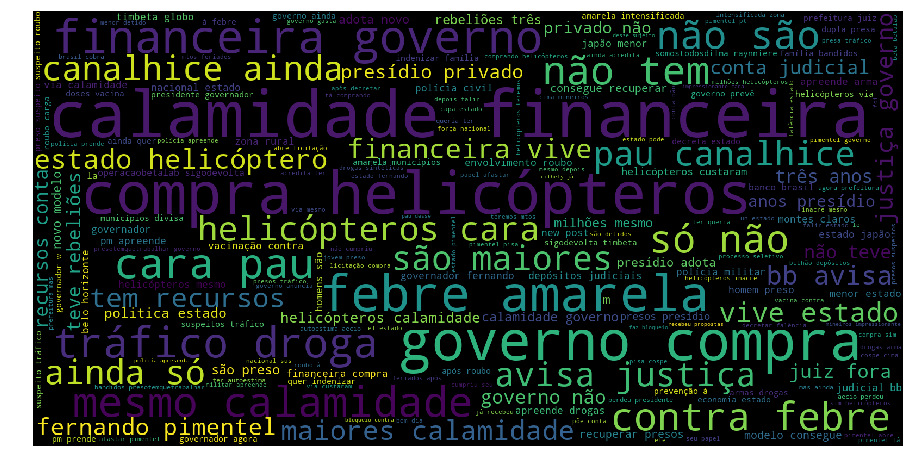

In [10]:
#gera nuvem de palavras ap√≥s a limpeza da base de treinamento
all_content=' '.join(df_treinamento['text'])
nuvem(all_content)

## Defini√ß√£o dos par√¢metros de vetoriza√ß√£o (bigrama)

In [181]:
#vectorizer = CountVectorizer(analyzer="word")
vectorizer = CountVectorizer(ngram_range = (1, 2))

## Treinamento

In [182]:
freq_tweets = vectorizer.fit_transform(df_treinamento['text'])
print("Total de palavras aprendidas:", len(vectorizer.vocabulary_))


Total de palavras aprendidas: 20648


## Defini√ß√£o do modelo - Naive Bayes

In [183]:
modelo = MultinomialNB()
modelo.fit(freq_tweets,df_treinamento['sentiment'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Avalia√ß√£o

In [184]:
resultados = cross_val_predict(modelo, freq_tweets, df_treinamento['sentiment'], cv = 10)
print("Acur√°cia Naive Bayes: ", metrics.accuracy_score(df_treinamento['sentiment'], resultados))

Acur√°cia Naive Bayes:  0.8927217125382263


## Relat√≥rio de classifica√ß√£o

In [159]:
sentimentos = [1, -1, 0]
print(metrics.classification_report(df_treinamento['sentiment'], resultados, sentimentos))

             precision    recall  f1-score   support

          1       0.96      0.89      0.92      3314
         -1       0.88      0.95      0.91      2438
          0       0.83      0.85      0.84      2423

avg / total       0.90      0.89      0.89      8175



## Defini√ß√£o do modelo - Random Forest

In [32]:
#define par√¢metros de vetoriza√ß√£o - bigrama
vectorizer = CountVectorizer(max_features=1000, ngram_range = (1, 2))                

data_features = vectorizer.fit_transform(df_treinamento['text'])
data_features = data_features.toarray()    

labels = df_treinamento['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=11)

forest = RandomForestClassifier(n_estimators=12, n_jobs=6)

#marca o tempo de treinamento
inicio_forest=time.time()
forest = forest.fit(X_train, y_train)
print("Acur√°cia Random Forest:", np.mean(cross_val_score(forest, data_features, labels, cv=10)))
fim_forest=time.time()

print("Tempo de treinamento e valida√ß√£o: ", fim_forest-inicio_forest, " segundos")

Acur√°cia Random Forest: 0.8379249429726567
Tempo de treinamento e valida√ß√£o:  4.849757194519043  segundos


## Carga do dataset de testes

In [185]:
df_resultados=pd.DataFrame([])

tw_rfb = pd.read_csv('D:/Pos_PUC/TCC/Datasets/Teste/toRFB_teste.csv', delimiter=";", encoding='utf-8')
tw_rfb.columns=['id', 'text', 'author_id', 'created_at']
with pd.option_context('display.max_colwidth', -1):     
  display(tw_rfb.sample(n=5, random_state=6))
   

id  \
8733   685046775636471808    
11073  129214780799066113    
1660   1300912735690031105   
2028   1281625031521570816   
190    1366135224707526664   

                                                                                                                                                                                                                                                                        text  \
8733   @ReceitaFederal Os caracteres anti rob√¥ da consulta optantes Simples n√£o est√° funcionando.  FAVOR VERIFICAR URGENTE. Assim desde ontem.                                                                                                                                 
11073  @PortalRFB Alguma previs√£o para o sistema de consulta de CPF voltar a funcionar? oO                                                                                                                                                                                     
1660   @ReceitaFederal @MinEconomia Aguardando REFIS para pessoa f√≠sica, com os descontos tbm üôèüèæüëçüèæ                                                                                                                                                                             
2028   @ReceitaFederal @MPF_PGR https://t.co/9olYtgDAMx                                                                                                                                                                                                                        
190    @ReceitaFederal Muito triste estou. Pq raz√£o est√£o penalizando pequenas empresas que precisam de refis? Regras novas para arrancar dinheiro de qualquer jeito? P dar aux√≠lio de gra√ßa ao inv√©s de nos ajudar p criarmos mais empregos?@jairbolsonaro @PauloGuedesReal   

                 author_id      created_at  
8733   858779556            16/01/07 10:34  
11073  57913023             11/10/26 15:16  
1660   1138190462559371264  20/09/01 21:45  
2028   1265647143827750917  20/07/10 16:23  
190    343675805            21/02/28 21:16

## Nuvem da base de testes (sem tratamento)

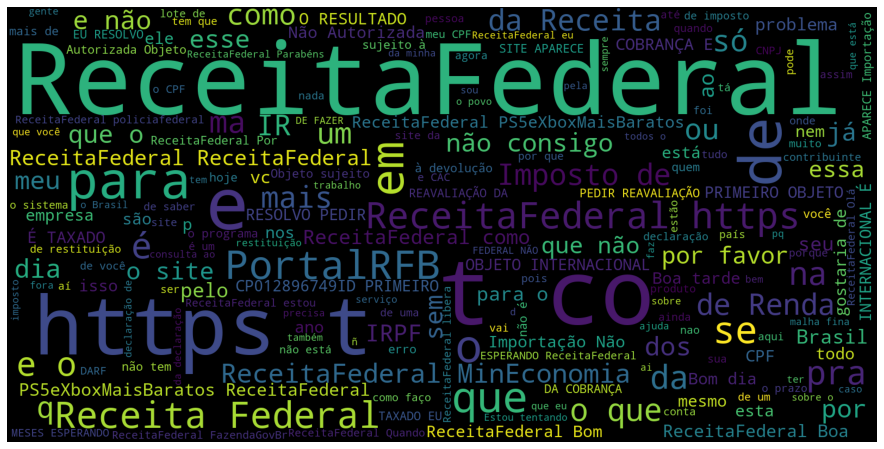

In [49]:
all_content=' '.join(tw_rfb['text'])
nuvem(all_content)

## Tratamento da base de testes

In [186]:
index = tw_rfb[tw_rfb['author_id'] == 18718638].index #remove tweets da RFB
tw_rfb.drop(index, inplace=True)
df_resultados['original']=tw_rfb['text'].copy()
df_resultados['date']=tw_rfb['created_at'].copy()
tw_rfb=limpaTexto(tw_rfb, "text")
testes=tw_rfb['text'].copy()

## Nuvem da base de testes (p√≥s tratamento)

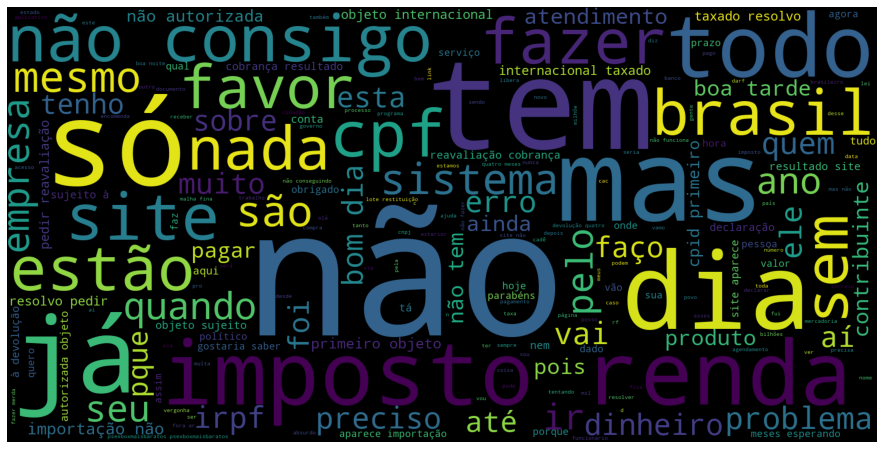

In [51]:
all_content=' '.join(tw_rfb['text'])
nuvem(all_content)

## Deploy do modelo - Naive Bayes

In [187]:
freq_testes = vectorizer.transform(testes)
a=[]
for t, c in zip (testes,modelo.predict(freq_testes)):
    a.append(c)
df_resultados['text']=testes
df_resultados['sentiment']=a    
with pd.option_context('display.max_colwidth', -1):     
  display(df_resultados[['original','text','sentiment']].head())


original  \
0  RT @BrasilAcima_: @ReceitaFederal \nPARTE PRA CIMA DO #COVID√ÉO! \nüí•üí•üí•üí•üí•üí•üí•\nüí•üí£üí£üí£üí£üí£üí•\nüí•üí£üí≤üí≤üí≤üí£üí•\nüí•üí£üí≤üêÄüí≤üí£üí•\nüí•üí£üí≤üí≤üí≤üí£üí•\nüí•üí£üí£üí£üí£üí£üí•\nüí•üí•üí•üí•üí•üí•üí•\n#Covid_19MIL \nhttps‚Ä¶                                                                                                                                                     
1  @ReceitaFederal E quando n√£o √© um assunto que se resolva de forma on LINE, e o pessoal que atende n√£o consegue auxiliar, como no caso dos parcelamentos do PERT que foram perdidos, n√£o voltam para os d√©bitos, n√£o permitem renegociar, e ficam constando nas pend√™ncias da empresa, qual recomenda√ß√£o?   
2  @ReceitaFederal ira atender os agendados presencialmente?                                                                                                                                                                                                                                                  
3  @ReceitaFederal A Live pode ser acessada, na data do evento, pelo endere√ßo: https://t.co/c2Unm7tRJ0                                                                                                                                                                                                        
4  @ReceitaFederal, coloque servidores que saibam abrir e-mails e seus anexos para responder e-mails. J√° √© a 4¬™ vez que tenho que explicar a minha solicita√ß√£o e reenviar toda a documenta√ß√£o pq os servidores n√£o sabem abrir anexos e/ou n√£o sabem ler/interpretar pedidos simples.                         

                                                                                                                                                                                                                    text  \
0  parte cima covid√£o covid_mil                                                                                                                                                                                            
1  quando n√£o assunto resolva forma on line pessoal atende n√£o consegue auxiliar caso parcelamentos peque foram perdidos n√£o voltam d√©bitos n√£o permitem renegociar ficam constando pend√™ncias empresa qual recomenda√ß√£o   
2  ira atender agendados presencialmente                                                                                                                                                                                   
3  live pode ser acessada data evento pelo endere√ßo                                                                                                                                                                        
4  coloque servidores saibam abrir mails seus anexos responder mails j√° ¬™ vez tenho explicar solicita√ß√£o reenviar toda documenta√ß√£o pque servidores n√£o sabem abrir anexos n√£o sabem ler interpretar pedidos simples       

   sentiment  
0 -1          
1  0          
2  1          
3  0          
4  0

## Resultados

In [65]:
df_resultados['sentiment'].count()

11292

In [66]:
df_resultados['sentiment'].value_counts(normalize=True)

-1    0.479543
 0    0.327666
 1    0.192791
Name: sentiment, dtype: float64

In [117]:
#amostra aleat√≥ria de 10 registros classificados como negativos no m√™s de janeiro de 2021.
with pd.option_context('display.max_colwidth', -1):     
  display(df_resultados[['original','date']].loc[(df_resultados['sentiment']==-1) & \
                                                        (df_resultados['date']>="21/01/01") &\
                                                        (df_resultados['date']<="21/01/31")].sample(n=10, random_state=2))

original  \
322  @ReceitaFederal Fiz a compra de um livro no exterior e est√° na alf√¢ndega aguardando pagamento! Livros n√£o s√£o isentos de impostos???? Aguardo resposta.                                                                                                                                     
380  @ReceitaFederal tenho um produto nos correios parado em Curitiba desde do dia 05/01 com status encaminhado para fiscaliza√ß√£o meu produto foi l√° sendo tratado como lixo, os correios servi√ßo de lixo n√£o resolvem nada. √â a ETC ou a RFB respons√°vel pela fiscaliza√ß√£o ?                    
445  @ReceitaFederal N√£o consigo usar o sistema SAL para gerar contribui√ß√£o individual para 01/2021, alguma previs√£o para resolver o problema? - diz que o valor do sal√°rio n√£o √© reconhecido.                                                                                                   
383  @ReceitaFederal @cfcbsb \n@PauloGuedesReal \nEnt√£o vai ter solu√ß√£o? J√° h√° centenas de reclama√ß√µes nas ouvidorias da RFB. DAS √© arrecada√ß√£o caso n√£o saibam serve para pagar o salario de voc√™s tamb√©m. Esse inferno esta dando erro desde o inicio da semana passada. Pretendem resolver?   
407  @ReceitaFederal Eu gostaria de saber cad√™ a porra do item que eu comprei meses atr√°s e que voc√™s n√£o s√≥ seguraram sem motivo nenhum ainda passam da porra do prazo de 30 dias para fazer a maldita an√°lise, J√Å SE PASSARAM 44 DIAS PORRA                                                    
340  @ReceitaFederal @tcu\nEssas notas fiscais no portal, s√£o quentes?????\nhttps://t.co/COsOeRoY8G                                                                                                                                                                                              
428  @receitafederal muita burocracia!!! A segunda via da declara√ß√£o do imposto de renda do ano de 2018 √© imposs√≠vel!                                                                                                                                                                            
434  @ReceitaFederal @ReceitaFederal pe√ßam aos desenvolvedores do EFD-Contribui√ß√µes para alterarem o munic√≠pio de Mogi-Mirim. Esta escrito Moji, o que causa erro na valida√ß√£o do arquivo importado.                                                                                             
425  @ReceitaFederal Amados, estamos com um erro no download do arquivo do Programa Gerador da Declara√ß√£o Dirf 2021. Poderiam verificar pra n√≥s?                                                                                                                                                 
378  @ReceitaFederal faz a porra de um site decente seus filhosdaputa                                                                                                                                                                                                                            

               date  
322  21/01/30 03:41  
380  21/01/19 11:27  
445  21/01/06 14:51  
383  21/01/18 20:15  
407  21/01/16 03:06  
340  21/01/27 17:58  
428  21/01/11 17:03  
434  21/01/09 14:55  
425  21/01/12 17:08  
378  21/01/19 16:13

## Grava√ß√£o dos resultados

In [55]:
df_resultados.to_csv("D:/Pos_PUC/TCC/Datasets/resultado.csv")